# Yandex.Afisha marketing expenses optimization

Based on:

   - Server logs with data on Yandex.Afisha visits from June 2017 through May 2018
   - Dump file with all orders for the period
   - Marketing expenses statistics

let's study:

   - How people use the product
   - When they start to buy
   - How much money each customer brings
   - When they pay off

### Step 1. Download the data and prepare it for analysis

Store the data on visits, orders, and expenses in variables. Optimize the data for analysis. Make sure each column contains the correct data type. 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

In [2]:


# load data partially to investigate the fields
visits = pd.read_csv('visits_log_us.csv', nrows=500)
orders = pd.read_csv('orders_log_us.csv', nrows=500)
costs = pd.read_csv('costs_us.csv', nrows=500)

visits.info(memory_usage='deep')


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Device     500 non-null    object
 1   End Ts     500 non-null    object
 2   Source Id  500 non-null    int64 
 3   Start Ts   500 non-null    object
 4   Uid        500 non-null    uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 113.1 KB


We have 3 fields of object types to investigate for **visits**:
- Device
- Start Ts
- End Ts

In [3]:
visits['Device'].value_counts()

desktop    363
touch      137
Name: Device, dtype: int64

In [4]:
visits['End Ts'].describe()

count                     500
unique                    499
top       2018-03-09 17:40:00
freq                        2
Name: End Ts, dtype: object

In [5]:
visits['Start Ts'].describe()

count                     500
unique                    499
top       2017-11-16 12:22:00
freq                        2
Name: Start Ts, dtype: object

In [6]:
# Device field has only 2 values so it looks like a category field, 
# while Start Ts and End Ts are dates.
visits = pd.read_csv('visits_log_us.csv', 
                     nrows=500,
                     dtype={'Device': 'category'},
                     parse_dates=['Start Ts', 'End Ts'])
visits.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Device     500 non-null    category      
 1   End Ts     500 non-null    datetime64[ns]
 2   Source Id  500 non-null    int64         
 3   Start Ts   500 non-null    datetime64[ns]
 4   Uid        500 non-null    uint64        
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 16.4 KB


Almost 10 times less memory used after the **visits DF** optimization (16.4 KB against 113.1 KB).

In [7]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [8]:
orders.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   500 non-null    object 
 1   Revenue  500 non-null    float64
 2   Uid      500 non-null    uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 45.0 KB


There's a single field of object type in **orders**:
- Buy Ts


In [9]:
orders['Buy Ts'].describe()

count                     500
unique                    476
top       2017-06-05 22:24:00
freq                        3
Name: Buy Ts, dtype: object

In [10]:
# Buy Ts should be a date.
orders = pd.read_csv('orders_log_us.csv', 
                     nrows=500,
                     parse_dates=['Buy Ts'])
orders.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Buy Ts   500 non-null    datetime64[ns]
 1   Revenue  500 non-null    float64       
 2   Uid      500 non-null    uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 11.8 KB


Almost 4 times less memory used after the **orders DF** optimization (45.0 KB against 11.8 KB).

In [11]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [12]:
costs.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  500 non-null    int64  
 1   dt         500 non-null    object 
 2   costs      500 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 40.7 KB


In [13]:
costs['dt'].describe()

count            500
unique           363
top       2017-07-22
freq               2
Name: dt, dtype: object

In [14]:
# Buy Ts should be a date.
costs = pd.read_csv('costs_us.csv', 
                     nrows=500,
                     parse_dates=['dt'])
costs.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  500 non-null    int64         
 1   dt         500 non-null    datetime64[ns]
 2   costs      500 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 11.8 KB


In [15]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Almost 3.4 times less memory used after the **costs DF** optimization (40.7 KB against 11.8 KB).

Now we're ready to load the whole dataframes using types conversion:

In [16]:
visits = pd.read_csv('visits_log_us.csv',                      
                     dtype={'Device': 'category'},
                     parse_dates=['Start Ts', 'End Ts'])
orders = pd.read_csv('orders_log_us.csv', parse_dates=['Buy Ts'])
costs = pd.read_csv('costs_us.csv', parse_dates=['dt'])

In [17]:
# Rename columns to lowcase names without spaces
visits.columns = ['device','end_ts','source_id', 'start_ts', 'uid']
orders.columns = ['buy_ts', 'revenue', 'uid']


In [18]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  category      
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB


In [19]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [20]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [21]:
visits.duplicated().sum()

0

In [22]:
orders.duplicated().sum()

0

In [23]:
costs.duplicated().sum()

0

In [24]:
# let's check that the data in visits is correct, e.g. start_ts is always <= end_ts 
visits[visits['start_ts'] > visits['end_ts']]['uid'].count()


2

In [25]:
visits.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [26]:
# let's look for zero length sessions, start_ts = end_ts 
visits[visits['start_ts'] == visits['end_ts']]['uid'].count()

35794

In [27]:
# Filter out incorrect records
visits = visits[visits['start_ts'] <= visits['end_ts']]


In [28]:
# Examine dates range
visits['start_ts'].describe()

count                  359398
unique                 224301
top       2017-11-24 16:06:00
freq                       19
first     2017-06-01 00:01:00
last      2018-05-31 23:59:00
Name: start_ts, dtype: object

In [29]:
orders['buy_ts'].describe()

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: buy_ts, dtype: object

Orders contain June data for 2017 and 2018

Let's count how many orders in 2018-06 and filter out the records from June 2018 to simplify analysis (to guarantee unique months)

In [30]:
# orders contain June data for 2017 and 2018
# let's count how many orders in 2018-06 and filter out the records from June 2018
# to simplify analysis (to guarantee unique months)
orders[orders['buy_ts'] > pd.to_datetime('2018-05-31 23:59:59')]

,buy_ts,revenue,uid
50414,2018-06-01 00:02:00,3.42,83872787173869366


In [31]:
orders = orders[orders['buy_ts'] <= pd.to_datetime('2018-05-31 23:59:59')]

In [32]:
costs['dt'].describe()

count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

In [33]:
# let's check the data in orders and look for zero revenue 
orders[orders['revenue'] ==0 ]['uid'].count()


51

In [34]:
# let's check the data in cossts and look for zero costs 
costs[costs['costs'] ==0 ]['dt'].count()

0

### Conclusions

- We've converted data types while loading the datasets.
- There're no missing or duplicated values in the datasets. 
- We've found ~35K records with zero length sessions and 2 records with incorrect values (session start is after session end)
- We've reduced the dataset omiting the incorrect records assuming that zero length sessions are applicable if they lasted less than a second.
- We've found a few (51) orders with zero revenue, we assume these are promo/discounted orders so we keep these records.
- We've filtered out 1 record from orders to guarantee all months are unique and do not overlap for different years. It'll simplify data manipulation.

In [35]:
# display(orders.head(), visits.head(), costs.head())


### Step 2. Make reports and calculate metrics

### 1. Product

  - How many people use it every day, week, and month?
  - How many sessions are there per day? (One user might have more than one session.)
  - What is the length of each session?
  - How often do users come back?

In [36]:
# 1. Let's add supplementary columns for year, month, week and date
visits['session_year']  = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week']  = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date

visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27


In [37]:
# 2. Let's calculate DAU, WAU and MAU
dau_total = visits.groupby('session_date').agg({'uid': 'nunique'}).mean()
wau_total = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean()
mau_total = visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean()

print("DAU is {}\nWAU is {}\nMAU is {}".format(int(dau_total),int(wau_total),int(mau_total)))


DAU is 907
WAU is 5716
MAU is 23228


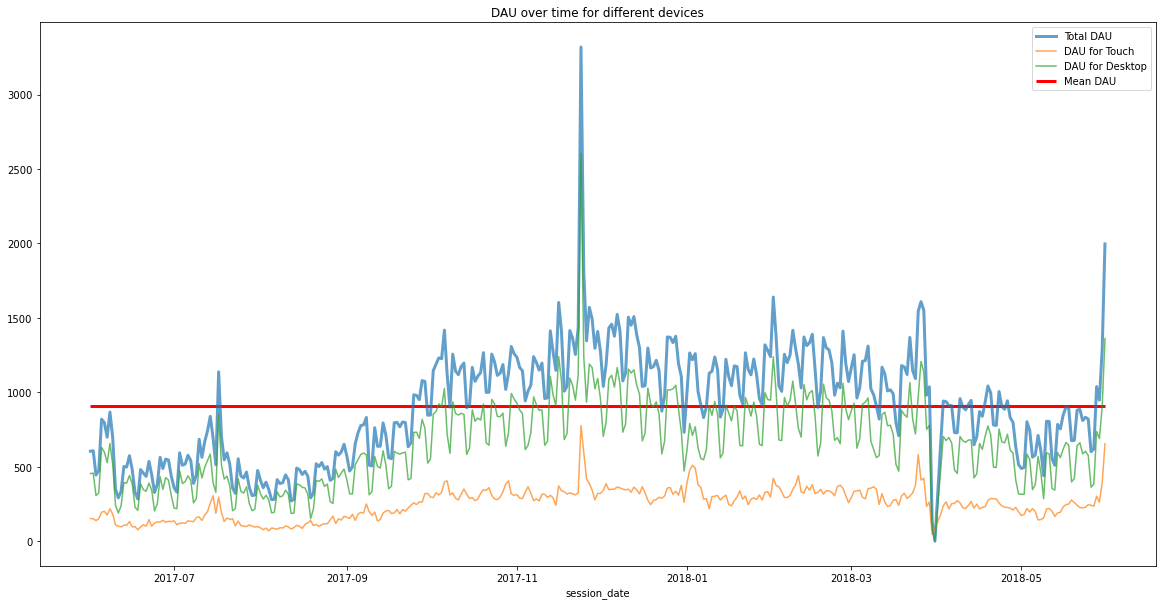

In [38]:
# Let's plot DAU over time 
ax = visits.groupby('session_date').agg({'uid': 'nunique'}).plot(kind='line', alpha=0.7, title='DAU over time for different devices',  figsize=(20,10), lw=3)
visits.query('device=="touch"').groupby('session_date').agg({'uid': 'nunique'}).plot(kind='line', alpha=0.7,  ax=ax)
visits.query('device=="desktop"').groupby('session_date').agg({'uid': 'nunique'}).plot(kind='line', alpha=0.7,  ax=ax)
plt.hlines(dau_total, visits['session_date'].min(), visits['session_date'].max(), colors=['red'], lw=3)
b= ax.legend(["Total DAU", "DAU for Touch", "DAU for Desktop", 'Mean DAU'])

DAU graph looks wavy (~4 waves per month which may coorespond to weeks).
There were a couple of outliers which may slightly influence the mean. The 1st peak outlier corresponds to the New Year's Eve when people are extremely involved into events. The second bottom outlier falls into April when people open village season and leave cities. Spring and summer are low seasons for the events (DAU value is below the mean value).
Also we see that **desktop** version is more popular compared to **touch** version.
Let's check if the median value significantly differs from the mean.

In [39]:
dau_median = visits.groupby('session_date').agg({'uid': 'nunique'}).median()
print("DAU median is {}".format(int(dau_median)))

DAU median is 921


The difference is 14 (~1.5%) so we can keep the mean value as the average DAU.

In [40]:
# Let's get the list of the sources
sources = visits['source_id'].unique()
sources.sort()
sources

array([ 1,  2,  3,  4,  5,  6,  7,  9, 10], dtype=int64)

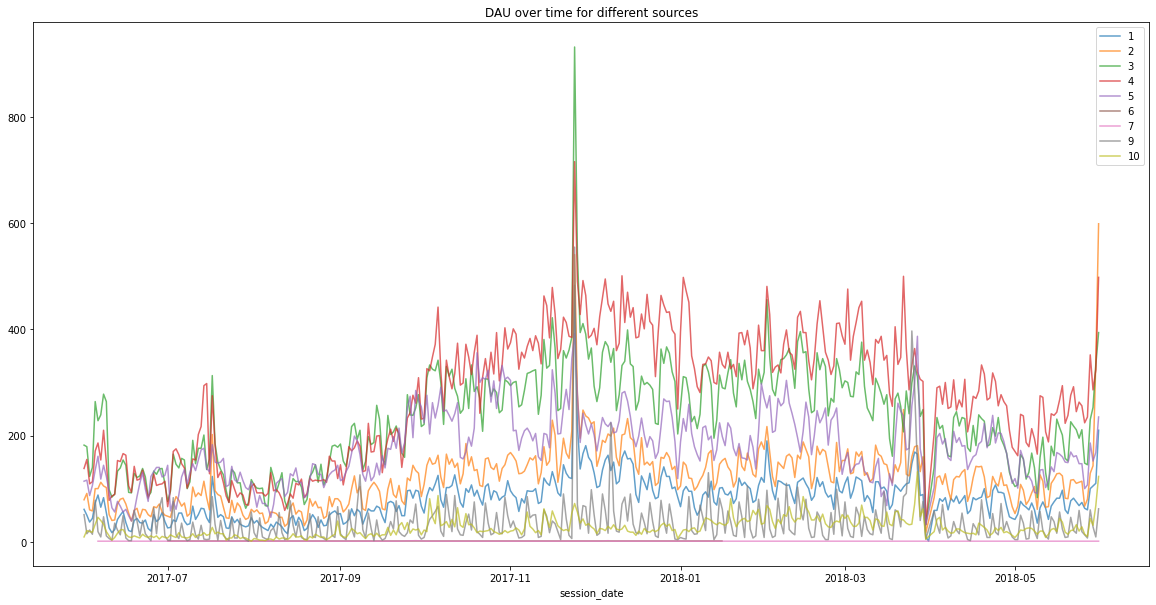

In [41]:
ax = visits.query('source_id==@sources[0]').groupby('session_date').agg({'uid': 'nunique'}).plot(kind='line', alpha=0.7, figsize=(20,10), title='DAU over time for different sources')
for source in sources:
    if(source==sources[0]):
        continue
    visits.query('source_id==@source').groupby('session_date').agg({'uid': 'nunique'}).plot(kind='line', alpha=0.7,  ax=ax)

ax.legend(sources)

We see that TOP5 sources are: 
- <font color='red'>source #4</font>, 
- <font color='green'>source #3 </font>, 
- <font color='purple'>source #5 </font>,
- <font color='orange'>source #2 </font>,
- <font color='blue'>source #1 </font>. 

Mainly they keep their places but sometimes source 3 takes the first place (e.g. in June, Septembre or on peak of New Year's period) as well as source 5 in the end of March, in August.

In [42]:
# 3. Let's calculate average sessions number per day

sessions_per_day = visits.groupby('session_date').agg({'uid': 'count'}).mean()
print("Average sessions number per day is", int(sessions_per_day))

Average sessions number per day is 987


In [43]:
# 4. Let's calculate additionally the number of sessions per user per day
sessions_per_user = visits.groupby('session_date').agg({'uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
sessions_per_user.head()

,n_sessions,n_users,sessions_per_user
session_date,,,
2017-06-01,664,605,1.097521
2017-06-02,658,608,1.082237
2017-06-03,477,445,1.071910
2017-06-04,510,476,1.071429
2017-06-05,893,820,1.089024


In [44]:
print("The average sessions number per user per day is", sessions_per_user['sessions_per_user'].mean())

The average sessions number per user per day is 1.0821660876897365


In [45]:
# Let's calculate the number of sessions per user per day for each device
sessions_per_user = visits.groupby(['session_date','device']).agg({'uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
sessions_per_user.head()

n_sessions  n_users  sessions_per_user
session_date device                                         
2017-06-01   desktop         501      455           1.101099
             touch           163      153           1.065359
2017-06-02   desktop         498      458           1.087336
             touch           160      152           1.052632
2017-06-03   desktop         329      307           1.071661

In [46]:
sess_touch = sessions_per_user.reset_index().query('device=="touch"')['sessions_per_user'].mean()
sess_desktop = sessions_per_user.reset_index().query('device=="desktop"')['sessions_per_user'].mean()
print("Average sessions per user per day:\nfor touch\t{},\nfor desktop\t{}".format(sess_touch, sess_desktop))

Average sessions per user per day:
for touch	1.051071574166503,
for desktop	1.0889496645509742


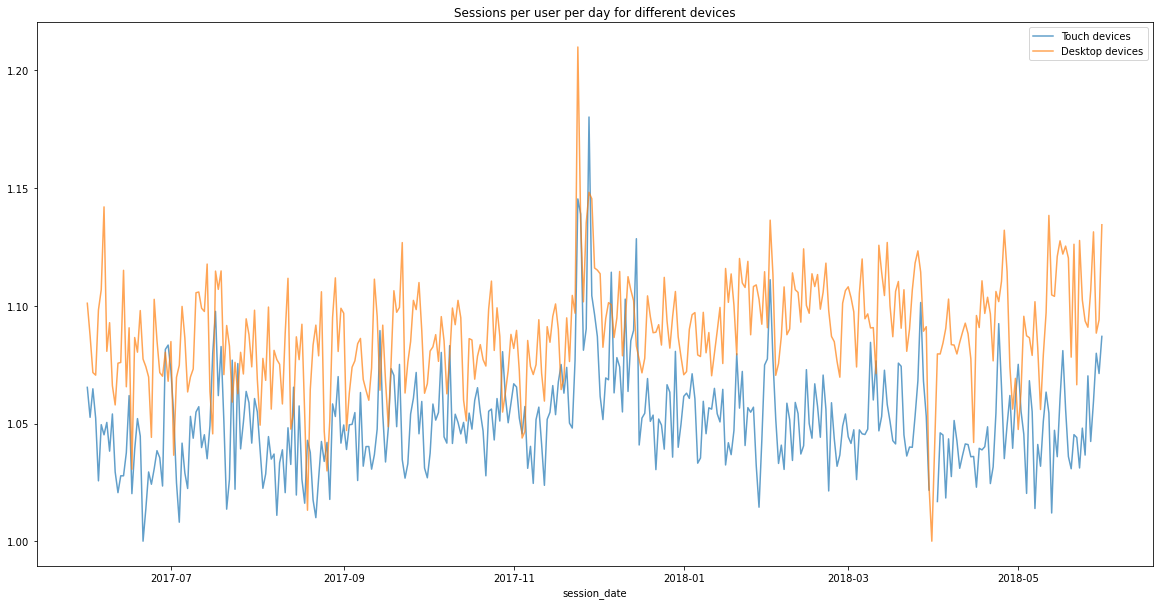

In [47]:
ax = sessions_per_user.reset_index().query('device=="touch"').plot(kind='line', x='session_date', y='sessions_per_user', alpha=0.7, figsize=(20,10), title='Sessions per user per day for different devices')
sessions_per_user.reset_index().query('device=="desktop"').plot(kind='line', x='session_date', y='sessions_per_user',alpha=0.7,  ax=ax)
ax.legend(["Touch devices", "Desktop devices"])

Desktop users open more sessions compared to touch devices users but not significantly more.
Except some peaks (e.g. pre-New Year peak) the session per user oscillates around the average values during the year.

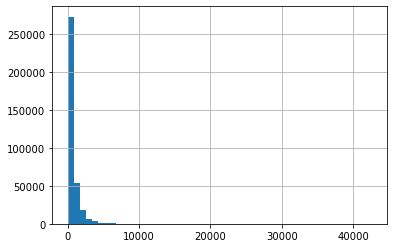

In [48]:
# 5. Let's calculate average session length

visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

visits['session_duration_sec'].hist(bins=50)


In [49]:
# Looking at the distribution which has no symmetry 
# we should use Mode as the average session time

asl = visits['session_duration_sec'].mode()
print('The average session length is', int(asl), 'seconds')

The average session length is 60 seconds


In [50]:
# 6. Let's see how often users come back by calculating sticky factors
print("The sticky factor DAU/WAU is", int(dau_total)/int(wau_total))
print("The sticky factor DAU/MAU is", int(dau_total)/int(mau_total))

The sticky factor DAU/WAU is 0.1586773967809657
The sticky factor DAU/MAU is 0.039047701050456345


In [51]:
# 7. Additionally let's calculate the retention rate based on cohorts

# get the first activity date for each user
first_activity_date = visits.groupby(['uid'])['session_date'].min()
first_activity_date.name = 'first_activity_date'
visits = visits.join(first_activity_date,on='uid')


In [52]:
# calculate month for the first activity and for the every visit 
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')
visits['activity_month'] = visits['session_date'].astype('datetime64[M]')


In [53]:
# calculate lifetime in months

visits['cohort_lifetime']=(visits['activity_month']-visits['first_activity_month'])/ np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')


In [54]:
# Build cohorts based on first activity month 
cohorts = visits.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()


In [55]:
# calculate initial users in cohort
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})


In [56]:
# add initial users count to the DF
cohorts = cohorts.merge(initial_users_count,on='first_activity_month')


# calculate the retention
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
cohorts['first_activity_month'] = cohorts['first_activity_month'].dt.strftime('%Y-%m')


In [57]:
# Build the pivot table
retention_pivot = cohorts.pivot_table(index='first_activity_month',columns='cohort_lifetime',values='retention',aggfunc='sum')
retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


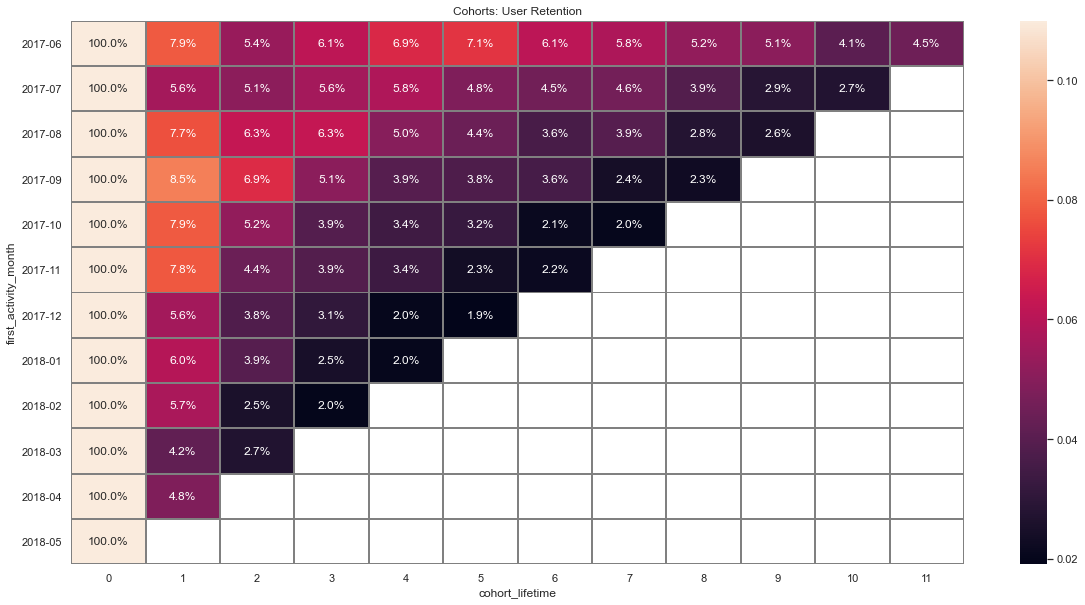

In [91]:
# Let's build the heatmap

sns.set(style='white')
plt.figure(figsize=(20, 10))
plt.title('Cohorts: User Retention')
ax = sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmax=0.11)
b=ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

We've got not so high retention rate values (<10%). The more lifetime month number the lower retention rate (it's mainly true for the last half of the lifetime compared to the first one).
The earliest cohort has relatively high retention rates (>5%) during the long period (up to 8M,9M).
Cohorts with users registered from August to Novembre also have good rates during the first several months (2-3).

### 2. Sales

  - When do people start buying? (the time that elapses between registration and conversion — when the user becomes a customer.)
  - How many orders do they make during a given period of time?
  - What is the average purchase size?
  - How much money do they bring? (LTV)

In [59]:
# display(orders.head(), visits.head(), costs.head())

In [60]:
# 1. Let's calculate the min visit TS (registration) 
#    and min order TS (the first buy)

first_activity_ts = visits.groupby(['uid'])['start_ts'].min()
first_activity_ts.name = 'first_activity_ts'
first_order_ts = orders.groupby(['uid'])['buy_ts'].min()
first_order_ts.name = 'first_order_ts'

orders = orders.join(first_activity_ts,on='uid')
orders = orders.join(first_order_ts,on='uid')
orders['time_to_customer'] = orders['first_order_ts']-orders['first_activity_ts']
orders.head()

,buy_ts,revenue,uid,first_activity_ts,first_order_ts,time_to_customer
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,2017-06-01 00:10:00,00:01:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2017-06-01 00:25:00,00:11:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,2017-06-01 00:27:00,00:02:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,2017-06-01 00:29:00,00:15:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,2017-06-01 07:58:00,00:27:00


In [61]:
orders.groupby('uid')['time_to_customer'].first().describe()

count                      36522
mean     16 days 21:40:50.532281
std      47 days 01:45:34.984683
min              0 days 00:00:00
25%              0 days 00:04:00
50%              0 days 00:16:00
75%              2 days 00:17:30
max            363 days 07:04:00
Name: time_to_customer, dtype: object

In 25% of all cases the first order occurs during 4 minutes from the 1st visit.
In 50% of all cases it takes no more than 16 minutes to make the 1st order after the registration.
In 75% of all cases  the first order appears during ~2 days from the registration.

In [62]:
# 2. Let's calculate how many orders every single user made over the time
orders_count = orders.groupby(['uid'])['buy_ts'].count()
orders_count.describe()

count    36522.000000
mean         1.380373
std          3.454508
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        239.000000
Name: buy_ts, dtype: float64

In [63]:
# Let's look at the TOP order counts
orders_count.value_counts().head(10)

1     30230
2      4395
3      1086
4       375
5       147
6        79
7        41
8        24
10       15
12       10
Name: buy_ts, dtype: int64

Out of 36.5K users who made orders:
- 30.2K users made only 1 order
- 4.3K users made 2 orders
- 1K users made 3 orders
- 0.37K users made 4 orders
- 0.14K users made 5 orders

So almost all users who made orders made not more than 5 orders (~36K users) during the year.

In [64]:
# get the number of orders for each user and add the info from visits 
# (specifically source_id and device)
order_visit = orders.groupby('uid')['revenue'].count().reset_index().merge(visits, on='uid', how='inner')



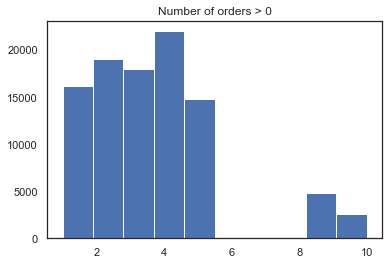

In [65]:

# make a set of histograms for users who made 1, 2, 3, ... orders to see 
# which sources become more significant as the number of orders per user increases
number_of_frames = 30

def update_hist(num, data):
    plt.cla()
    plt.hist(data.query('revenue>'+str(num))['source_id'],bins=10)
    plt.title('Number of orders > ' +str(num))

fig, ax = plt.subplots()
anim = animation.FuncAnimation(fig, update_hist, number_of_frames, fargs=(order_visit, ) )

HTML(anim.to_jshtml())

We see that the most valuable sources among people who became customers are:
- source 4
- source 2
- source 3
- source 1 
- source 5

But for the people who make more than 1 purchase the most significant sources are:
- source 2
- source 1

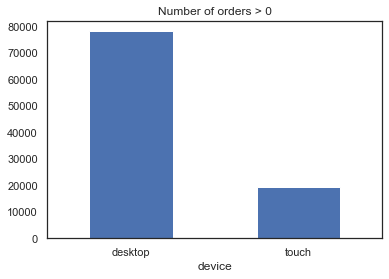

In [66]:
# make a set of histograms for users who made 1, 2, 3, ... orders to see 
# which devices become more significant as the number of orders per user increases
number_of_frames = 30

def update_hist(num, data):
    plt.cla()
    data.query('revenue>'+str(num)).groupby('device')['uid'].count().plot(kind='bar')
    plt.title('Number of orders > ' +str(num))
    plt.xticks(rotation='horizontal')

fig, ax = plt.subplots()

anim = animation.FuncAnimation(fig, update_hist, number_of_frames, fargs=(order_visit, ) )
HTML(anim.to_jshtml())

Mostly people make purchases from desktop devices and the more orders a single user makes the more is the share of desktop devices.

Now let's calculate the number of purchases made per month and the monthly conversion (in the sense of purchase percentage among visits).

In [67]:
# Let's calculate the conversion: what percentage of visits was converted into orders
# as months are unique we don't use year to group the data

orders['purchase_month'] = orders['buy_ts'].dt.month
orders['order_date'] = orders['buy_ts'].dt.date
orders['order_month'] = orders['order_date'].astype('datetime64[M]')
views = visits.groupby('session_month')['uid'].count()
purchases = orders.groupby('purchase_month')['uid'].count()
conversion = (purchases / views) *100
conversion.name = 'conversion'
orders = orders.join(conversion,on='purchase_month')
purchases

purchase_month
1     4721
2     5281
3     5326
4     3273
5     4346
6     2354
7     2363
8     1807
9     3387
10    5679
11    5659
12    6218
Name: uid, dtype: int64

Similar to DAU analysis in summer people make fewer purchases while before the New Year there's a hot season.

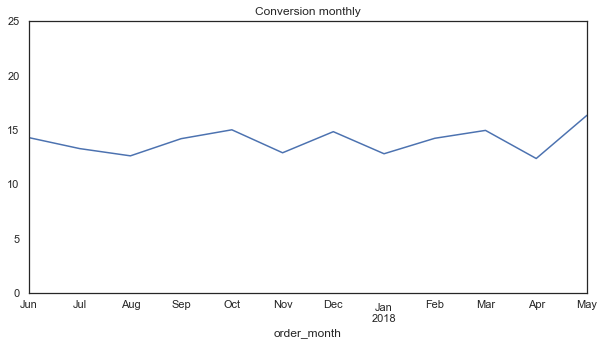

In [68]:
orders.groupby('order_month')['conversion'].first().plot(kind='line', ylim=(0,25), figsize=(10,5), title='Conversion monthly')

Conversion oscillates around 14% throughout the year.

In [69]:
# 3. Let's calculate purchase size per user based on cohorts
#    Calculate the first order date

first_order_date_by_customers = orders.groupby('uid')['order_date'].min()
first_order_date_by_customers.name = 'first_order_date'

# add first order date to orders and calculate first order month
orders = orders.join(first_order_date_by_customers,on='uid')
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')

In [70]:
orders.head()

,buy_ts,revenue,uid,first_activity_ts,first_order_ts,time_to_customer,purchase_month,order_date,order_month,conversion,first_order_date,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,2017-06-01 00:10:00,00:01:00,6,2017-06-01,2017-06-01,14.262345,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2017-06-01 00:25:00,00:11:00,6,2017-06-01,2017-06-01,14.262345,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,2017-06-01 00:27:00,00:02:00,6,2017-06-01,2017-06-01,14.262345,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,2017-06-01 00:29:00,00:15:00,6,2017-06-01,2017-06-01,14.262345,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,2017-06-01 07:58:00,00:27:00,6,2017-06-01,2017-06-01,14.262345,2017-06-01,2017-06-01


<a id='ans'> </a>

In [71]:

#add cohort sizes


# create cohorts and calculate revenue sum for each month and number of unique users
orders_grouped_by_cohorts = orders.groupby(['first_order_month','order_month']).agg({'revenue':'sum','uid':'nunique'})
orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index()
orders_grouped_by_cohorts['cohort_lifetime'] = (orders_grouped_by_cohorts['order_month'] - orders_grouped_by_cohorts['first_order_month'])/ np.timedelta64(1,'M')
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'].round().astype('int')
# format first order month
orders_grouped_by_cohorts['first_order_month_str'] = orders_grouped_by_cohorts['first_order_month'].dt.strftime('%Y-%m')
# calculate revenue per user
orders_grouped_by_cohorts['revenue_per_user'] = orders_grouped_by_cohorts['revenue'] / orders_grouped_by_cohorts['uid']
# build a pivot table to display revenue per user splited by cohorts 
revenue_per_user_pivot = orders_grouped_by_cohorts.pivot_table(index='first_order_month_str',columns='cohort_lifetime',values='revenue_per_user',aggfunc='mean')

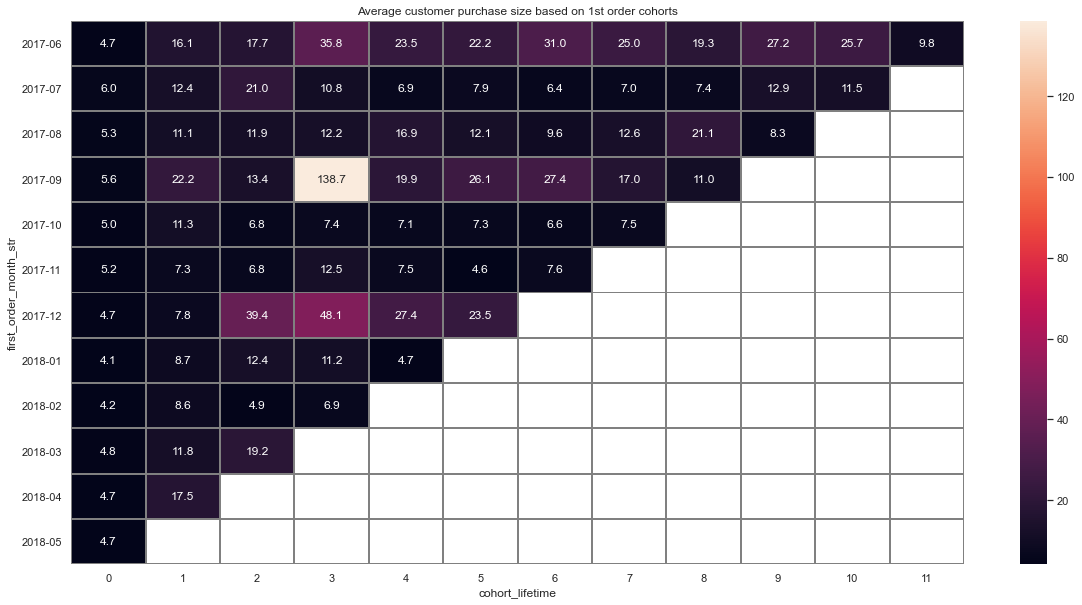

In [72]:
# build a heatmap
plt.figure(figsize=(20, 10))
plt.title('Average customer purchase size based on 1st order cohorts')
#plt.yticks(rotation=0)
ax = sns.heatmap(revenue_per_user_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray')
b=ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

- The earliest cohort brings steady and relatively high revenue (purchase size) over the year (~25)
- Septembre cohort has an outlier - unusually high revenue during the 3d lifetime month (138.7). The 3d month is Decembre, so it seems that it can be related to New Year.
- Decembre cohort has high values (23 - 48)

Let's calculate delta LTV, we assume that margin rate is 0.5.

In [73]:
# 4. Let's calculate delta LTV, we assume that margin rate is 0.5.

cohort_sizes = orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

report = pd.merge(cohort_sizes, orders_grouped_by_cohorts, on='first_order_month')

margin_rate = .5

report['gp'] = report['revenue'] * margin_rate
report['ltv'] = report['gp'] / report['n_buyers']

In [74]:
output = report.pivot_table(
    index='first_order_month_str', 
    columns='cohort_lifetime', 
    values='ltv', 
    aggfunc='mean').round(2)

#output = output.fillna('')
output

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month_str,,,,,,,,,,,,
2017-06,2.36,0.24,0.22,0.48,0.51,0.37,0.48,0.29,0.28,0.30,0.29,0.13
2017-07,3.01,0.17,0.31,0.18,0.09,0.08,0.06,0.07,0.08,0.07,0.08,NaN
2017-08,2.64,0.24,0.23,0.20,0.25,0.14,0.11,0.20,0.15,0.09,NaN,NaN
2017-09,2.82,0.56,0.26,1.99,0.20,0.32,0.35,0.12,0.09,NaN,NaN,NaN
2017-10,2.50,0.27,0.10,0.08,0.08,0.06,0.04,0.06,NaN,NaN,NaN,NaN
2017-11,2.58,0.20,0.10,0.16,0.07,0.03,0.06,NaN,NaN,NaN,NaN,NaN
2017-12,2.37,0.13,0.46,0.53,0.16,0.17,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,2.07,0.15,0.15,0.07,0.03,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,2.08,0.14,0.04,0.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
# 3.1. Let's calculate purchase size per cohort user based on cohorts

# calculate revenue per cohort user
report['revenue_per_user'] = report['revenue'] / report['n_buyers']
# build a pivot table to display revenue per user splited by cohorts 
revenue_per_cohort_user_pivot = report.pivot_table(index='first_order_month_str',columns='cohort_lifetime',values='revenue_per_user',aggfunc='mean')

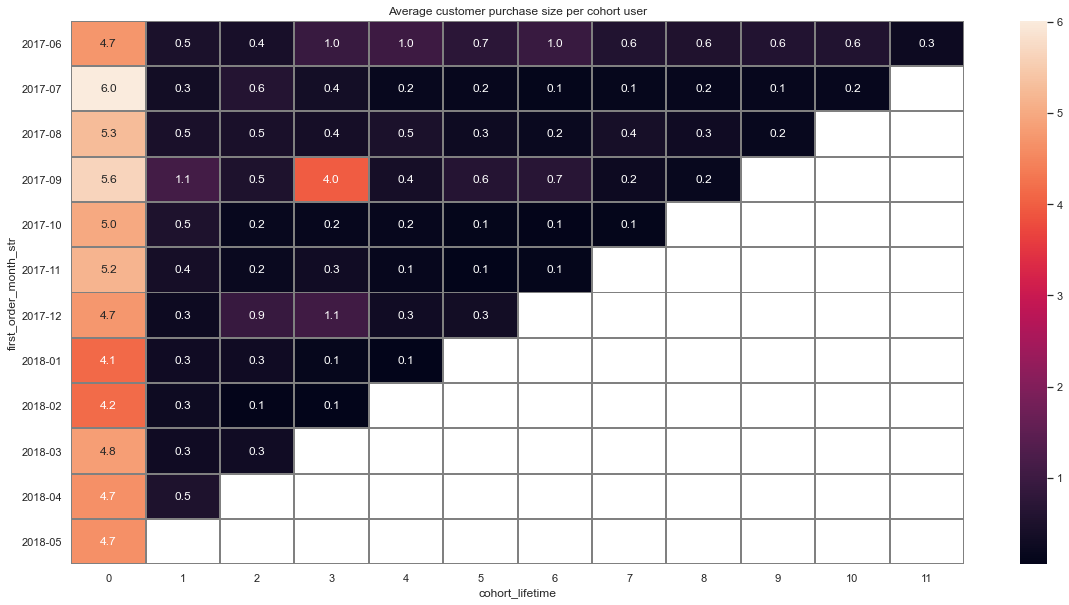

In [76]:
# build a heatmap
plt.figure(figsize=(20, 10))
plt.title('Average customer purchase size per cohort user')
ax = sns.heatmap(revenue_per_cohort_user_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray')
b=ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

Now let's calculate cumulative LTV per each cohort

In [77]:
output.cumsum(axis=1).round(2)

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month_str,,,,,,,,,,,,
2017-06,2.36,2.60,2.82,3.30,3.81,4.18,4.66,4.95,5.23,5.53,5.82,5.95
2017-07,3.01,3.18,3.49,3.67,3.76,3.84,3.90,3.97,4.05,4.12,4.20,NaN
2017-08,2.64,2.88,3.11,3.31,3.56,3.70,3.81,4.01,4.16,4.25,NaN,NaN
2017-09,2.82,3.38,3.64,5.63,5.83,6.15,6.50,6.62,6.71,NaN,NaN,NaN
2017-10,2.50,2.77,2.87,2.95,3.03,3.09,3.13,3.19,NaN,NaN,NaN,NaN
2017-11,2.58,2.78,2.88,3.04,3.11,3.14,3.20,NaN,NaN,NaN,NaN,NaN
2017-12,2.37,2.50,2.96,3.49,3.65,3.82,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,2.07,2.22,2.37,2.44,2.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,2.08,2.22,2.26,2.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


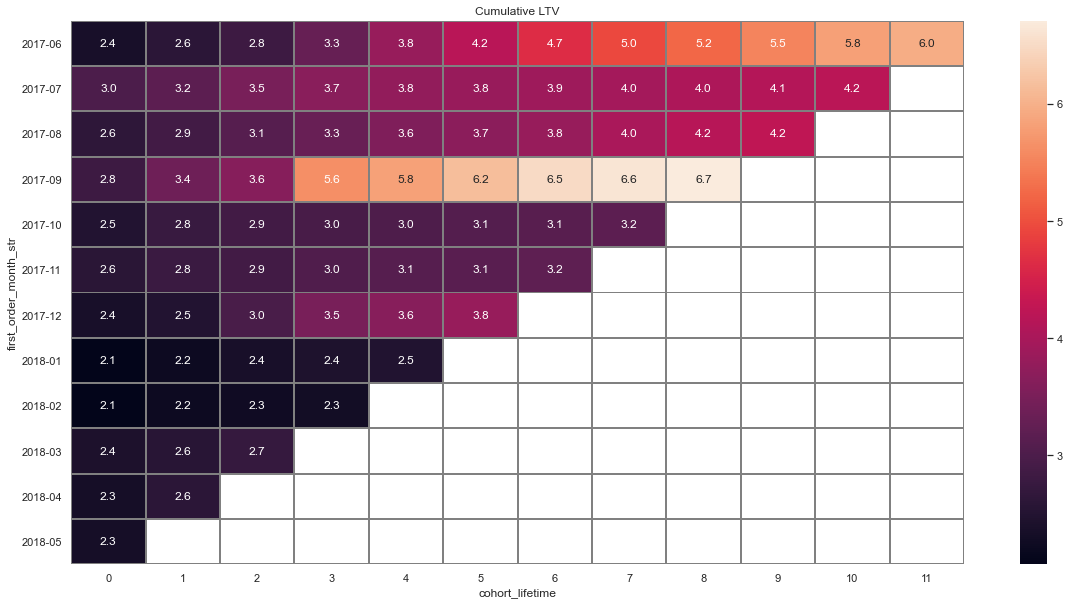

In [78]:
cum_ltv_all_pivot = output.cumsum(axis=1).round(2)
# build a heatmap
plt.figure(figsize=(20, 10))
plt.title('Cumulative LTV')
ax = sns.heatmap(cum_ltv_all_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray')
b=ax.set_yticklabels(ax.get_yticklabels(), rotation=0)

<a id='enrich'></a>

We'll use the calculated LTV below for the general ROMI calculation. As we need to determine the most profitable marketing sources we'll calculate LTV per source. But first we need to prepare orders DF.

Let's now enrich orders DF with source_id and device columns. 
We'll use two methods:
1. Try to match buy_ts from orders with the interval (start_ts, end_ts) from visits OR if no match found we'll get the nearest end_ts assuming a small lag in time between visit logs and orders log. The disadvantage of the method is its complexity and time consumption but it's more accurate (different user's orders may have different source_id).
2. Group visits DF by (uid, source_id) and count source_id. Then we'll choose the winner by the majority of source usages so every user's order will have the same source_id. It's simpler but it may contain errors (not always there's a majority etc.).

At the end we'll compare the differences to estimate how inaccurate the second method is.


In [79]:
# we're starting with the first method
# Make index interval based on start_ts and end_ts
visits.index = pd.IntervalIndex.from_arrays(visits['start_ts'],visits['end_ts'],closed='both')

prepare a function to find the matches between 2 DFs

In [80]:
# prepare a function to find the matches between 2 DFs
def match_source(x):
    match = visits[visits['uid']==x['uid']]
    try:
        return match.iloc[(match.index.get_loc(x['buy_ts']))][['source_id','device']]
    except KeyError:
        # we'll have exceptions when buy_ts does not match any interval
        # we label it as undef for further processing
        return ['undef','undef']


In [81]:
# apply the matching finction and add the column
orders[['source_id', 'device']] = orders.apply(lambda x : match_source(x), axis=1)
orders[orders['source_id']=='undef']['uid'].count()

14488

In [82]:
# we continue by preparing another index based on end_ts
visits.index = pd.Index(visits['end_ts'])
visits = visits.sort_index()


prepare another matching function based on nearest matching method

if buy_ts is out of intervals we find the nearest visit.

In [83]:
def match_source(x):
    if x['source_id']!="undef":
        return x[['source_id','device']]
    match = visits[visits['uid']==x['uid']]
    try:
        return match.iloc[(match.index.get_loc(x['buy_ts'],'nearest'))][['source_id','device']]
    except KeyError:        
        return ['undef','undef']



In [84]:
orders[['source_id', 'device']] = orders.apply(lambda x : match_source(x), axis=1)

In [85]:
# check that no undefined values
orders.query('source_id=="undef" or device=="undef"')

,buy_ts,revenue,uid,first_activity_ts,first_order_ts,time_to_customer,purchase_month,order_date,order_month,conversion,first_order_date,first_order_month,source_id,device


Let's try the second method of source_id extraction group by uid and source_id and count how often user was brought by each source

In [86]:
# Let's try the second method of source_id extraction
# group by uid and source_id and count how often user was brought by each source
users_sources = visits.groupby(['uid','source_id'])['source_id'].count()
users_sources.name = 'source_count'
users_sources = users_sources.reset_index()
# Choose the source with the max frequency
index = users_sources.groupby('uid')['source_count'].idxmax()

users_sources = users_sources.loc[index]
users_sources.columns=['uid','source_emp', 'source_count']
# add the empirical source to orders
orders = orders.merge(users_sources, on='uid')


In [87]:
#Check the accuracy of the second method
wrong_orders = orders[orders['source_id']!=orders['source_emp']]
wrong_orders.head()

,buy_ts,revenue,uid,first_activity_ts,first_order_ts,time_to_customer,purchase_month,order_date,order_month,conversion,first_order_date,first_order_month,source_id,device,source_emp,source_count
8,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01 09:22:00,2017-06-01 09:22:00,0 days,6,2017-06-01,2017-06-01,14.262345,2017-06-01,2017-06-01,1,desktop,5,99
13,2017-06-07 15:05:00,2.57,3644482766749211722,2017-06-01 09:22:00,2017-06-01 09:22:00,0 days,6,2017-06-07,2017-06-01,14.262345,2017-06-01,2017-06-01,2,desktop,5,99
14,2017-06-09 13:15:00,3.97,3644482766749211722,2017-06-01 09:22:00,2017-06-01 09:22:00,0 days,6,2017-06-09,2017-06-01,14.262345,2017-06-01,2017-06-01,2,desktop,5,99
24,2017-07-03 16:44:00,5.50,3644482766749211722,2017-06-01 09:22:00,2017-06-01 09:22:00,0 days,7,2017-07-03,2017-07-01,13.254431,2017-06-01,2017-06-01,4,desktop,5,99
36,2017-07-13 14:40:00,3.67,3644482766749211722,2017-06-01 09:22:00,2017-06-01 09:22:00,0 days,7,2017-07-13,2017-07-01,13.254431,2017-06-01,2017-06-01,1,desktop,5,99


In [88]:
wrong_orders.tail()

,buy_ts,revenue,uid,first_activity_ts,first_order_ts,time_to_customer,purchase_month,order_date,order_month,conversion,first_order_date,first_order_month,source_id,device,source_emp,source_count
50328,2018-05-31 20:32:00,17.60,17503836752284267299,2018-05-30 17:43:00,2018-05-31 18:37:00,1 days 00:54:00,5,2018-05-31,2018-05-01,16.316876,2018-05-31,2018-05-01,3,touch,2,1
50339,2018-05-31 19:15:00,33.24,12650795391896494494,2017-08-26 03:56:00,2018-05-31 19:15:00,278 days 15:19:00,5,2018-05-31,2018-05-01,16.316876,2018-05-31,2018-05-01,5,desktop,1,6
50340,2018-05-31 19:41:00,30.80,12650795391896494494,2017-08-26 03:56:00,2018-05-31 19:15:00,278 days 15:19:00,5,2018-05-31,2018-05-01,16.316876,2018-05-31,2018-05-01,5,desktop,1,6
50372,2018-05-31 21:22:00,6.23,5291123048634376500,2018-05-30 10:33:00,2018-05-31 21:22:00,1 days 10:49:00,5,2018-05-31,2018-05-01,16.316876,2018-05-31,2018-05-01,10,desktop,2,1
50387,2018-05-31 22:11:00,0.30,10999828041850243290,2017-07-04 12:42:00,2018-05-31 22:11:00,331 days 09:29:00,5,2018-05-31,2018-05-01,16.316876,2018-05-31,2018-05-01,3,desktop,4,2


In [89]:
wrong_orders['source_emp'].count()

11401

There're a lot of badly determined sources by the second method so we'll continue with the source_id column.

Let's now plot monthly conversion based on source and device and then calculate LTV for every source_id. Later we'll use it to determine the most profitable sources.

In [97]:
# Calculate conversion per source by grouping by month and source_id
views_sources = visits.groupby(['session_month','source_id'])['uid'].count()
purchases_sources = orders.groupby(['purchase_month','source_id'])['uid'].count()
views_sources.index.set_names(['purchase_month', 'source_id'], inplace=True)
conversion = (purchases_sources / views_sources) *100
conversion.name = 'conversion_source'
conversion = conversion.reset_index()
orders = orders.merge(conversion, on=['purchase_month', 'source_id'])

In [98]:
orders.groupby(['order_month', 'source_id'] )['conversion_source'].first().unstack(level=1)

source_id,1,2,3,4,5,7,9,10
order_month,,,,,,,,
2017-06-01,21.113990,14.148791,14.475761,11.071337,15.246637,NaN,7.897934,21.383648
2017-07-01,20.597197,14.147910,11.365762,11.858246,13.708087,NaN,9.339775,14.956012
2017-08-01,20.863309,13.236870,9.268565,11.795027,13.399941,100.0,11.257310,16.356877
2017-09-01,24.879923,15.305785,11.750246,11.552409,15.303334,NaN,10.526316,16.296296
2017-10-01,23.705058,17.427833,12.864589,12.571538,15.078887,NaN,12.778731,21.215139
2017-11-01,20.761399,13.691650,11.034994,11.349547,12.651599,NaN,12.342720,13.636364
2017-12-01,22.793449,18.170515,13.389552,12.446744,14.668588,NaN,9.992963,13.231198
2018-01-01,20.415014,14.796679,11.283655,11.093291,13.647096,NaN,11.623932,7.838480
2018-02-01,22.760432,16.093182,12.073290,12.362715,15.600833,NaN,10.873440,10.905203


Sources #6 and #7 have no conversion so we'll exclude them from the future analysis

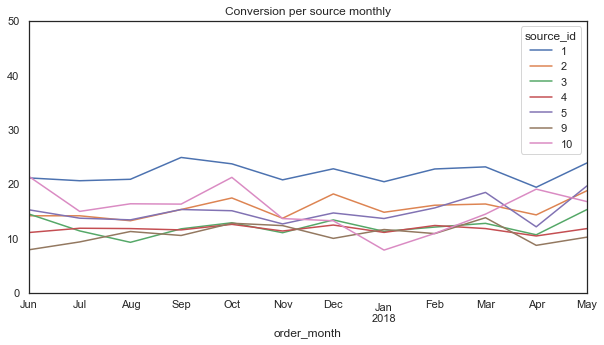

In [99]:
orders.groupby(['order_month', 'source_id'] )['conversion_source'].first().unstack(level=1).dropna(axis='columns', thresh=2).dropna(thresh=2).plot(kind='line', ylim=(0,50), figsize=(10,5), title='Conversion per source monthly')

From the conversion point of view the following sources are the leaders:
- source #1
- source #2
- source #5

Source #10 was among leaders in the first half of the period then some months it had bad conversion.

In [100]:
# Calculate conversion per device by grouping by month and device
views_devices = visits.groupby(['session_month','device'])['uid'].count()
purchases_devices = orders.groupby(['purchase_month','device'])['uid'].count()
views_devices.index.set_names(['purchase_month', 'device'], inplace=True)
conversion = (purchases_devices / views_devices) *100
conversion.name = 'conversion_device'
conversion = conversion.reset_index()
orders = orders.merge(conversion, on=['purchase_month', 'device'])

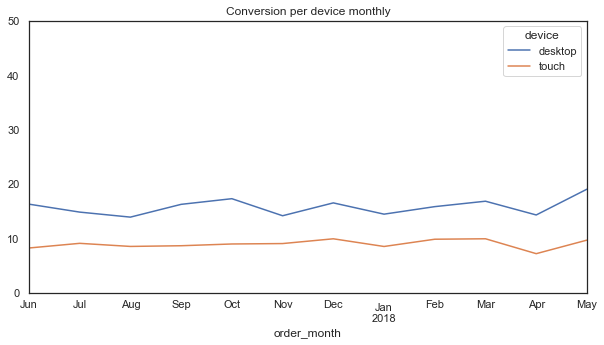

In [101]:
orders.groupby(['order_month', 'device'] )['conversion_device'].first().unstack(level=1).plot(kind='line', ylim=(0,50), figsize=(10,5), title='Conversion per device monthly')

As we've seen above desktop devices have better conversion rate compared to touch devices (almost 2 times). 

Let's calculate **delta** LTV for each source id

In [102]:
# 5. Let's calculate delta LTV for each source id

cohort_sizes = orders.groupby(['first_order_month', 'source_id']).agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month','source_id', 'n_buyers']

# create cohorts based on source and first order month and calculate revenue sum for each month 
# and number of unique users
orders_grouped_by_cohorts_source = orders.groupby(['first_order_month','order_month', 'source_id']).agg({'revenue':'sum','uid':'nunique'})
orders_grouped_by_cohorts_source = orders_grouped_by_cohorts_source.reset_index()
orders_grouped_by_cohorts_source['cohort_lifetime'] = (orders_grouped_by_cohorts_source['order_month'] - orders_grouped_by_cohorts_source['first_order_month'])/ np.timedelta64(1,'M')
orders_grouped_by_cohorts_source['cohort_lifetime'] = orders_grouped_by_cohorts_source['cohort_lifetime'].round().astype('int')
# format first order month
orders_grouped_by_cohorts_source['first_order_month_str'] = orders_grouped_by_cohorts_source['first_order_month'].dt.strftime('%Y-%m')

report_ltv_source = pd.merge(cohort_sizes, orders_grouped_by_cohorts_source, on=['first_order_month','source_id'])

margin_rate = .5

report_ltv_source['gp'] = report_ltv_source['revenue'] * margin_rate
report_ltv_source['ltv'] = report_ltv_source['gp'] / report_ltv_source['n_buyers']

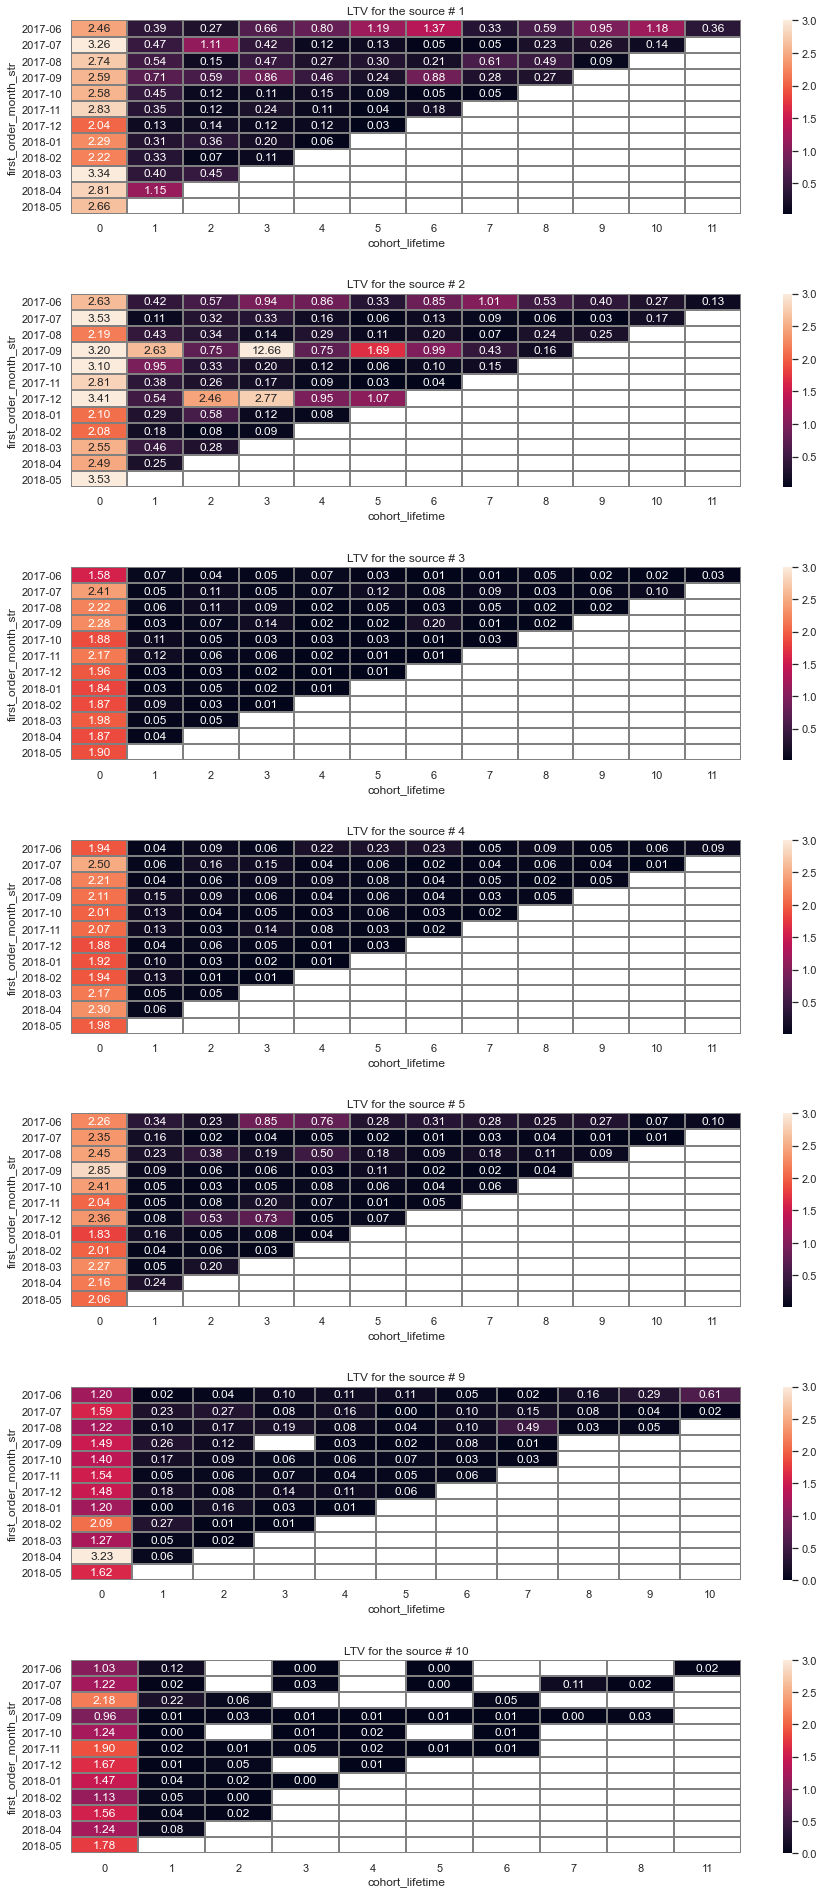

In [103]:
fig = plt.figure(figsize=(15, 40))
plt.title("LTV for different sources")
i=0
for source in sources:
    if source == 6 or source == 7:
        continue
    output = report_ltv_source.query("source_id==@source").pivot_table(
    index='first_order_month_str', 
    columns='cohort_lifetime', 
    values='ltv', 
    aggfunc='mean').round(2)
          
    ax1 = plt.subplot2grid((32, 12), (4*i, 0), colspan=12, rowspan=3)
    ax1.set_title("LTV for the source # " + str(source), fontsize=12)    
    
    sns.heatmap(output, annot=True, fmt='.2f', linewidths=1, linecolor='gray', ax=ax1, vmax=3)
    i = i+1      
plt.show()

1. There're marketing sources with low LTV:
 - Sources #3, #4, #9 and #10 (extremely low values compared to other sources, we should look at CAC to understand the effectiveness)
 
2. Sources #1 and #2 seem to be leaders.

Let's now build **cumulative** LTV heatmaps per source

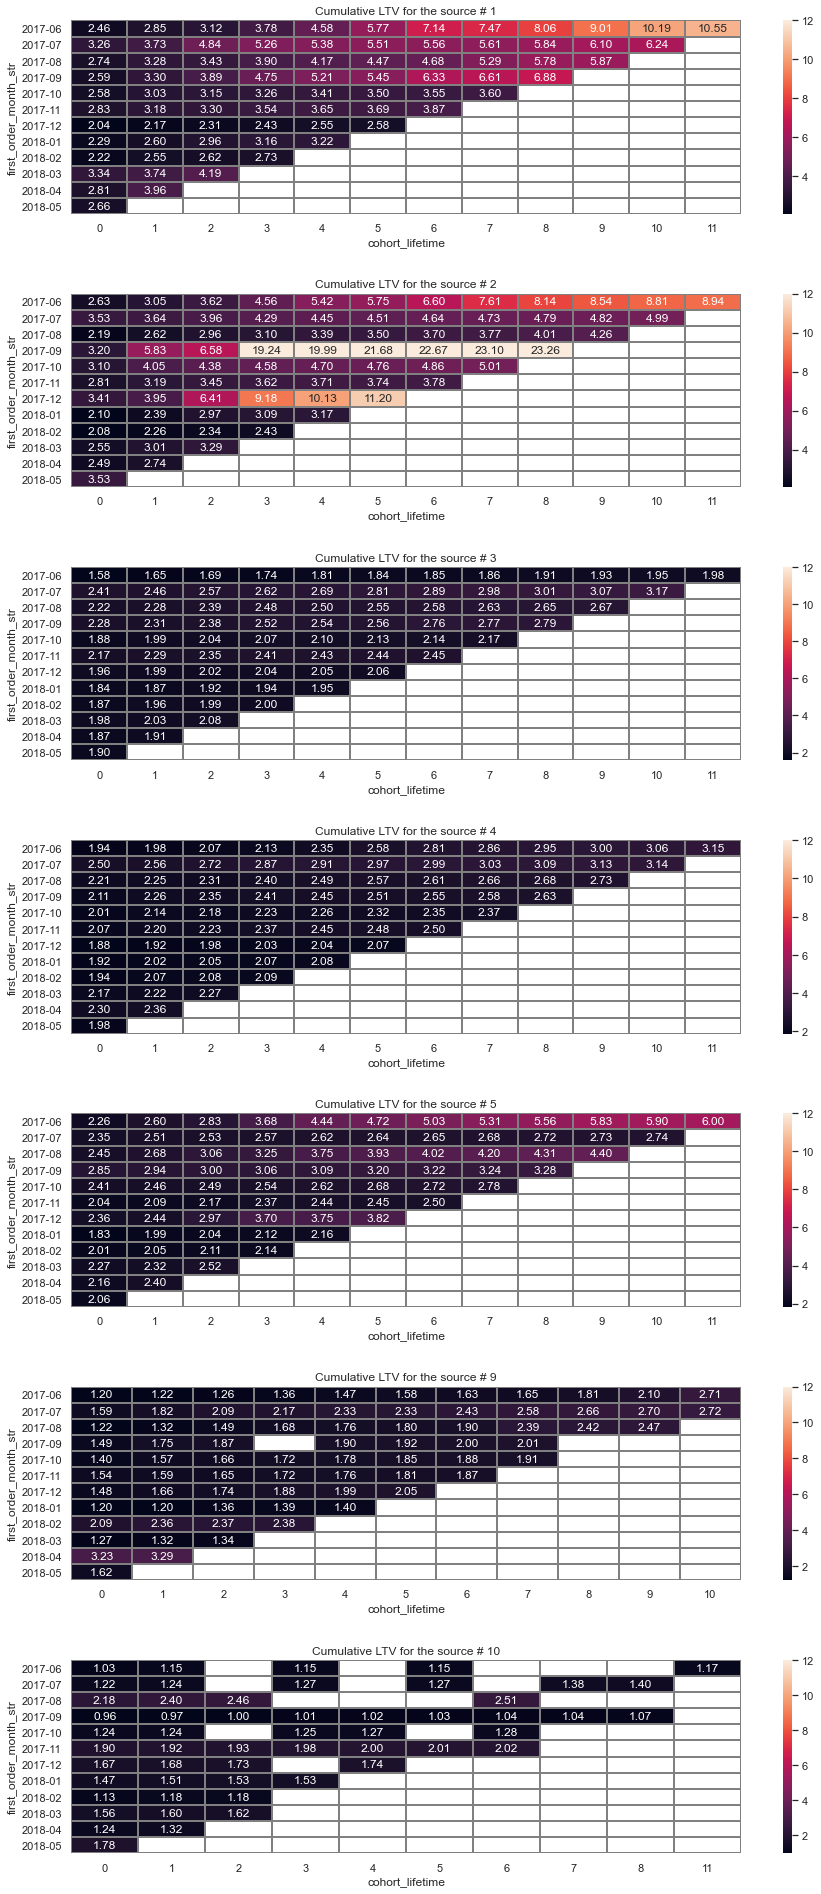

In [104]:
fig = plt.figure(figsize=(15, 40))
plt.title("Cumulative LTV for different sources")
i=0
for source in sources:
    if source == 6 or source == 7:
        continue
    output = report_ltv_source.query("source_id==@source").pivot_table(
    index='first_order_month_str', 
    columns='cohort_lifetime', 
    values='ltv', 
    aggfunc='mean').round(2)
    cum_ltv_pivot = output.cumsum(axis=1).round(2)     
    ax1 = plt.subplot2grid((32, 12), (4*i, 0), colspan=12, rowspan=3)
    ax1.set_title("Cumulative LTV for the source # " + str(source), fontsize=12)    
    
    sns.heatmap(cum_ltv_pivot, annot=True, fmt='.2f', linewidths=1, linecolor='gray', ax=ax1, vmax=12)
    i = i+1      
plt.show()

### 3. Marketing
  - How much money was spent? Overall/per source/over time
  - How much did customer acquisition from each of the sources cost?
  - How worthwhile were the investments? (ROI)

Plot graphs to display how these metrics differ for various devices and ad sources and how they change in time. 

In [105]:
# 1. Let's calculate how much money was spent
# overall during the year
costs['costs'].sum()


329131.62

In [106]:
# per source
costs.groupby('source_id')['costs'].sum().sort_values()


source_id
9       5517.49
10      5822.49
1      20833.27
2      42806.04
5      51757.10
4      61073.60
3     141321.63
Name: costs, dtype: float64

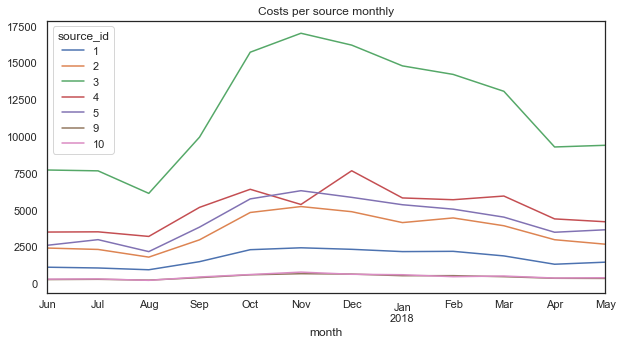

In [107]:
# over time (monthly)
costs['month'] = costs['dt'].astype('datetime64[M]')
costs_source_monthly = costs.groupby(['month','source_id'])['costs'].sum()

costs_source_monthly.unstack(level=1).plot(kind='line', figsize=(10,5), title='Costs per source monthly')


The cheapest sources are:
 - sources #9, #10 which are not effective in conversion or LTV
 - sources #1, #2 which are simultaneously effective in conversion and LTV
 
The most expensive source is source #3 which is several times (3 and more) more expensive the rest of the sources.

In [108]:
# 2. Calculate CAC (costs per user) for each source monthly
# prepare costs grouped by source_id and month to match the index in LTV DF
costs_source_monthly.index.set_names(['first_order_month','source_id'],inplace=True)
# group orders by source and get the number of unique users
cohort_users = report_ltv_source.groupby(['first_order_month','source_id'])['n_buyers'].first()

CAC = costs_source_monthly / cohort_users
CAC.head()

first_order_month  source_id
2017-06-01         1             3.562057
                   2             7.561931
                   3            11.768113
                   4             7.575000
                   5             5.749714
dtype: float64

In [109]:
# 3. First, let's get the general ROMI 


monthly_costs = costs.groupby('month').sum()

report_ = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')
report_['cac'] = report_['costs'] / report_['n_buyers']

report_['romi'] = report_['ltv'] / report_['cac']
output = report_.pivot_table(
    index='first_order_month', 
    columns='cohort_lifetime', 
    values='romi', 
    aggfunc='mean')

output.cumsum(axis=1).round(2)
#output = output.fillna('')


cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.27,0.29,0.32,0.37,0.43,0.47,0.52,0.56,0.59,0.62,0.65,0.67
2017-07-01,0.32,0.33,0.37,0.39,0.40,0.40,0.41,0.42,0.43,0.43,0.44,NaN
2017-08-01,0.24,0.27,0.29,0.31,0.33,0.34,0.35,0.37,0.38,0.39,NaN,NaN
2017-09-01,0.30,0.36,0.39,0.60,0.62,0.65,0.69,0.70,0.71,NaN,NaN,NaN
2017-10-01,0.30,0.33,0.34,0.35,0.36,0.37,0.37,0.38,NaN,NaN,NaN,NaN
2017-11-01,0.28,0.30,0.31,0.33,0.34,0.34,0.34,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.27,0.29,0.34,0.40,0.42,0.44,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.21,0.22,0.24,0.25,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.23,0.25,0.25,0.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
output.cumsum(axis=1).mean(axis=0)

cohort_lifetime
0     0.270408
1     0.290992
2     0.315535
3     0.359870
4     0.391473
5     0.429938
6     0.448410
7     0.484976
8     0.526936
9     0.482244
10    0.547329
11    0.666991
dtype: float64

In [111]:
cac_pivot = report_.pivot_table(
    index='first_order_month_str', 
    columns='cohort_lifetime', 
    values='cac', 
    aggfunc='mean')

romi_pivot = cum_ltv_all_pivot / cac_pivot
romi_pivot.round(2)

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month_str,,,,,,,,,,,,
2017-06,0.27,0.29,0.32,0.37,0.43,0.47,0.52,0.56,0.59,0.62,0.65,0.67
2017-07,0.32,0.34,0.37,0.39,0.40,0.40,0.41,0.42,0.43,0.43,0.44,NaN
2017-08,0.24,0.27,0.29,0.31,0.33,0.34,0.35,0.37,0.39,0.39,NaN,NaN
2017-09,0.30,0.36,0.39,0.60,0.62,0.65,0.69,0.70,0.71,NaN,NaN,NaN
2017-10,0.30,0.33,0.34,0.35,0.36,0.37,0.37,0.38,NaN,NaN,NaN,NaN
2017-11,0.28,0.30,0.31,0.33,0.33,0.34,0.34,NaN,NaN,NaN,NaN,NaN
2017-12,0.27,0.29,0.34,0.40,0.42,0.44,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,0.21,0.22,0.24,0.25,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,0.23,0.25,0.25,0.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


General picture is not that good. The service was not paid off at all during the year.

Let's calculate ROMI per source to determine the most profitable sources.

In [112]:
report_sources = pd.merge(report_ltv_source, costs_source_monthly, left_on=['first_order_month','source_id'], right_on=['first_order_month','source_id'])
report_sources['cac'] = report_sources['costs'] / report_sources['n_buyers']

report_sources['romi'] = report_sources['ltv'] / report_sources['cac']





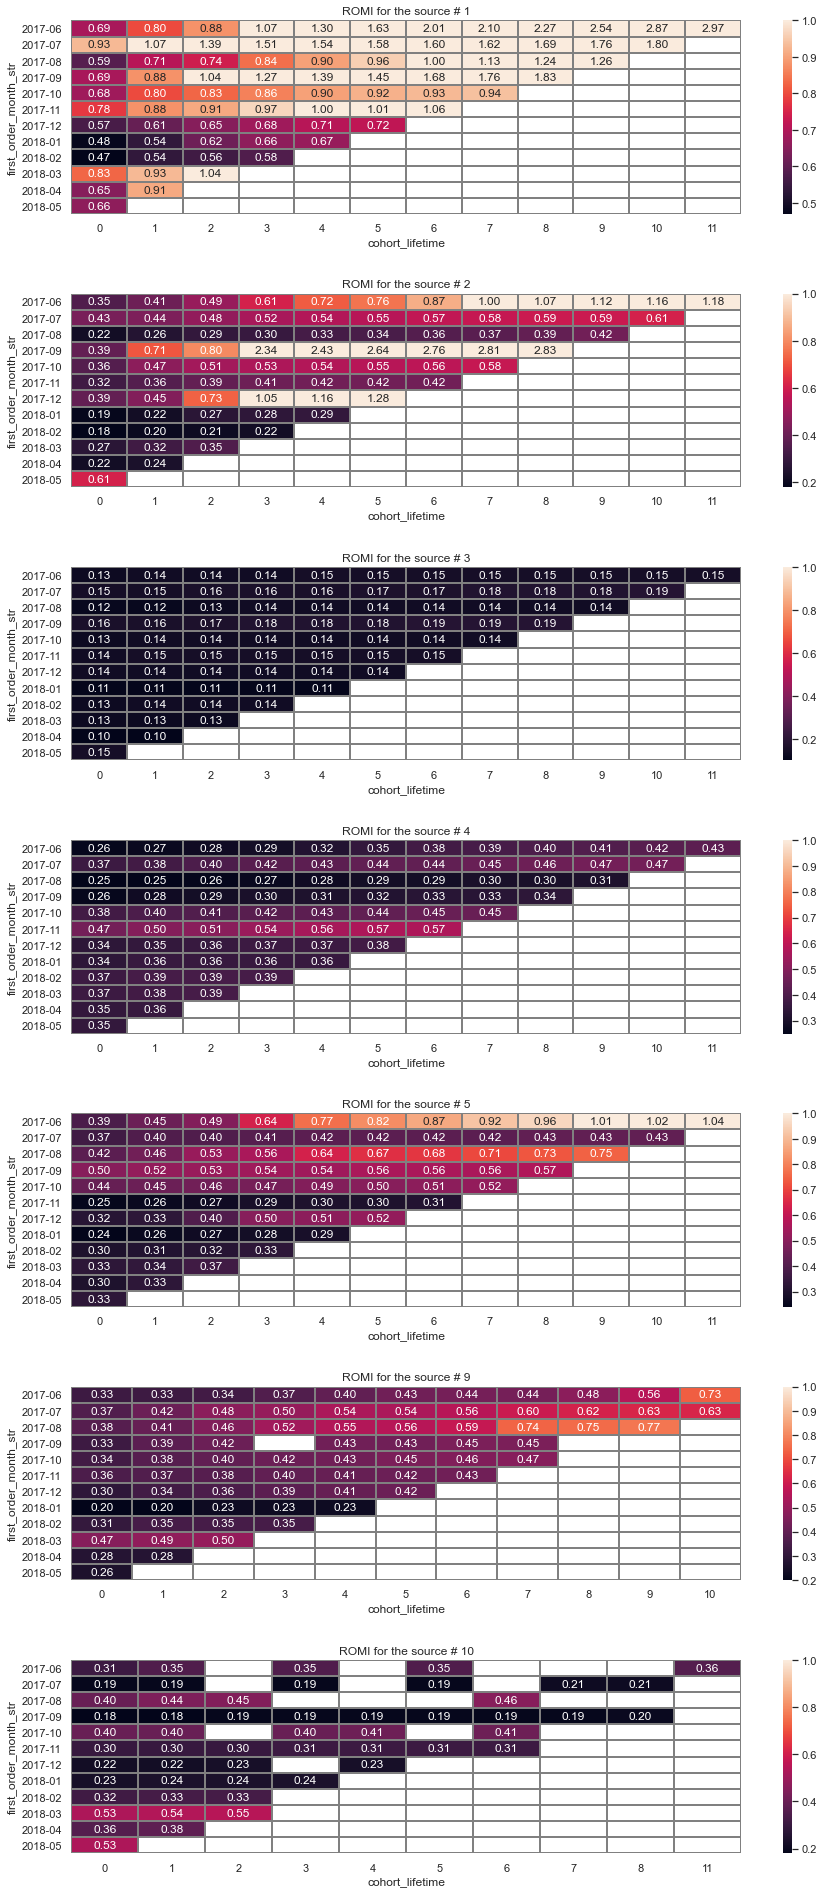

In [113]:
fig = plt.figure(figsize=(15, 40))
plt.title("ROMI for different sources")
i=0
# list to keep average ROMI for the sources
ROMI_sources=[]
for source in sources:
    if source == 6 or source == 7:
        continue
    output = report_sources.query("source_id==@source").pivot_table(
    index='first_order_month_str', 
    columns='cohort_lifetime', 
    values='romi', 
    aggfunc='mean').round(2)
    output = output.cumsum(axis=1).round(2)

    ROMI_sources.append(output.mean(axis=0))
    ax1 = plt.subplot2grid((32, 12), (4*i, 0), colspan=12, rowspan=3)
    ax1.set_title("ROMI for the source # " + str(source), fontsize=12)    
    
    sns.heatmap(output, annot=True, fmt='.2f', linewidths=1, linecolor='gray', ax=ax1,vmax =1)
    i = i+1      
plt.show()

In [114]:
i=0
for source in sources:
    if source == 6 or source == 7:
        continue    
    print('Average monthly ROMI for source #', str(source))    
    print(ROMI_sources[i])
    i = i+1

Average monthly ROMI for source # 1
cohort_lifetime
0     0.668333
1     0.788182
2     0.866000
3     0.937778
4     1.051250
5     1.181429
6     1.380000
7     1.510000
8     1.757500
9     1.853333
10    2.335000
11    2.970000
dtype: float64
Average monthly ROMI for source # 2
cohort_lifetime
0     0.327500
1     0.370909
2     0.452000
3     0.695556
4     0.803750
5     0.934286
6     0.923333
7     1.068000
8     1.220000
9     0.710000
10    0.885000
11    1.180000
dtype: float64
Average monthly ROMI for source # 3
cohort_lifetime
0     0.132500
1     0.134545
2     0.141000
3     0.144444
4     0.146250
5     0.152857
6     0.156667
7     0.160000
8     0.165000
9     0.156667
10    0.170000
11    0.150000
dtype: float64
Average monthly ROMI for source # 4
cohort_lifetime
0     0.342500
1     0.356364
2     0.365000
3     0.373333
4     0.382500
5     0.398571
6     0.410000
7     0.384000
8     0.375000
9     0.396667
10    0.445000
11    0.430000
dtype: float64
Average mont

1. Marketing investments from sources #3, 4 , 9, 10 are not paid off at all and have the low ROMI, so we should exclude them from the investment program together with sources 6,7 which are not converted at all (see above).
2. Sources #1 and #2 are the best profitable sources: source #1 is paid off on average from the 4th month while source #2 - from the 7th month.
3. Septembre and Decembre cohorts from source #2 are very successful, they pay off from the 3d month. For source #1 almost all cohorts are successful and they pay off during the first 3 months.
4. Source #5 is paid off on average only to the end of the year so we it's not as effective as #1 and #2.

Let's estimate the investments into source #1 and #2 based on cumulative average LTV: 
- for source #1 till the month #4
- for source #2 till the month #7

In [115]:
output = report_ltv_source.query("source_id==1").pivot_table(
    index='first_order_month_str', 
    columns='cohort_lifetime', 
    values='ltv', 
    aggfunc='mean').round(2)
m4_cum_ltv_source1 = output.mean(axis=0).cumsum()[4]
print("Average cumulative LTV for the source #1 till the 4th month is", m4_cum_ltv_source1.round(2))


Average cumulative LTV for the source #1 till the 4th month is 4.08


In [116]:
output = report_ltv_source.query("source_id==2").pivot_table(
    index='first_order_month_str', 
    columns='cohort_lifetime', 
    values='ltv', 
    aggfunc='mean').round(2)
m7_cum_ltv_source2 = output.mean(axis=0).cumsum()[7]
print("Average cumulative LTV for the source #2 till the 7th month is", m7_cum_ltv_source2.round(2))
m4_cum_ltv_source2 = output.mean(axis=0).cumsum()[4]
print("Average cumulative LTV for the source #2 till the 4th month is", m4_cum_ltv_source2.round(2))

Average cumulative LTV for the source #2 till the 7th month is 7.56
Average cumulative LTV for the source #2 till the 4th month is 6.35


### Step 3. Write a conclusion: advise marketing experts how much money to invest and where.


### Conclusion

1. Based on per source analysis of DAU, CR (conversion rate) and ROMI it turns out that the most efficient marketing sources are **source #1** and **source #2**, they pay off on average in the 4th-7th months but for some cohorts even faster. 
2. At the same time sources #3,4,9,10 are inefficient based on ROMI and and they didn't pay off, sources 6,7 have no conversion and source #5 pays off (on average) to the end of the year which is also inefficient. So we should stop investing into these sources.
3. Based on cumulative LTV calculations we recommend to invest:
 - into source #1 using CAC < $\$4.08$ if we expect it to pay off by the 4th month
 - into source #2 using CAC < $\$7.56$ if we expect it to pay off by the 7th month and
 - into source #2 using CAC < $\$6.35$ if we expect it to pay off by the 4th month
                        
4. We've seen that some cohorts from source #2 are the most profitable, namely Septembre and Decembre cohorts so marketing should pay attention to promotion during this periods.

5. Based on CR (conversion rate) we've seen that desktop devices are more often used to make purchases (conversion rate almost 2 times higher compared to the conversion for touch devices). So we'd recomment to promote applications and maarketing campaigns targeted to desktop users.